### Comparative Analysis of ARIMA and Neural Network Models for forecasting International Flight Departures
#### Team 17 : Anisha Dsouza (anishavd), Prathamesh Joshi (prathuj), Saideepti Seelam Veera Naga (svnsdeep)

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error


import xgboost as xgb

pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
# plt.style.use("dark_background")
import seaborn as sns
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')

# reviews_sample.columns.str.strip().str.lower().str.replace(' ', '_')

<style>
    .my-background {
        background-color: #FFEA00; /* Specify your desired color */
        padding: 10px;
        color: #000000;
        border-radius: 10px; /* Adjust the radius as needed */
    
        
    }
</style>

<div class="my-background">
    <h1>EDA</h1>
    <!-- Add your content here -->
</div>

In [2]:
dept_1 = pd.read_csv("International_Report_Departures.csv")
dept_1.tail()

,data_dte,Year,Month,usg_apt_id,usg_apt,usg_wac,fg_apt_id,fg_apt,fg_wac,airlineid,carrier,carriergroup,type,Scheduled,Charter,Total
930803,07/01/2000,2000,7,13303,MIA,33,13605,NAS,204,20398,MQ,1,Departures,1422,0,1422
930804,04/01/2019,2019,4,13303,MIA,33,14286,PTY,162,19770,CM,0,Departures,1439,0,1439
930805,08/01/2000,2000,8,13303,MIA,33,13605,NAS,204,20398,MQ,1,Departures,1441,0,1441
930806,09/01/2004,2004,9,12266,IAH,74,15632,VSA,148,19534,AM,0,Departures,1461,0,1461
930807,05/01/1996,1996,5,12478,JFK,22,14210,POS,280,19542,BW,0,Departures,2019,0,2019


In [4]:
# groupby date and count IDs
dept_2 = dept_1.groupby('data_dte')[['Year']].count()
dept_2.index.names = ['date']
dept_2.columns = ['count']
dept_3 = dept_2.reset_index()
# convert date to datetime
dept_3['date'] = pd.to_datetime(dept_3['date'])
dept_3.sort_values(by='date', inplace=True)
dept_3.reset_index(drop=True, inplace=True)
dept_3.tail()

,date,count
358,2019-11-01,3126
359,2019-12-01,3209
360,2020-01-01,3268
361,2020-02-01,3197
362,2020-03-01,3185


In [5]:
def plot_time_series(list, df):
    plt.figure(figsize=(20, 10))
    for i in list:
        plt.plot(df['date'], df[i], label=i, marker='o')
    plt.legend()
    plt.show()

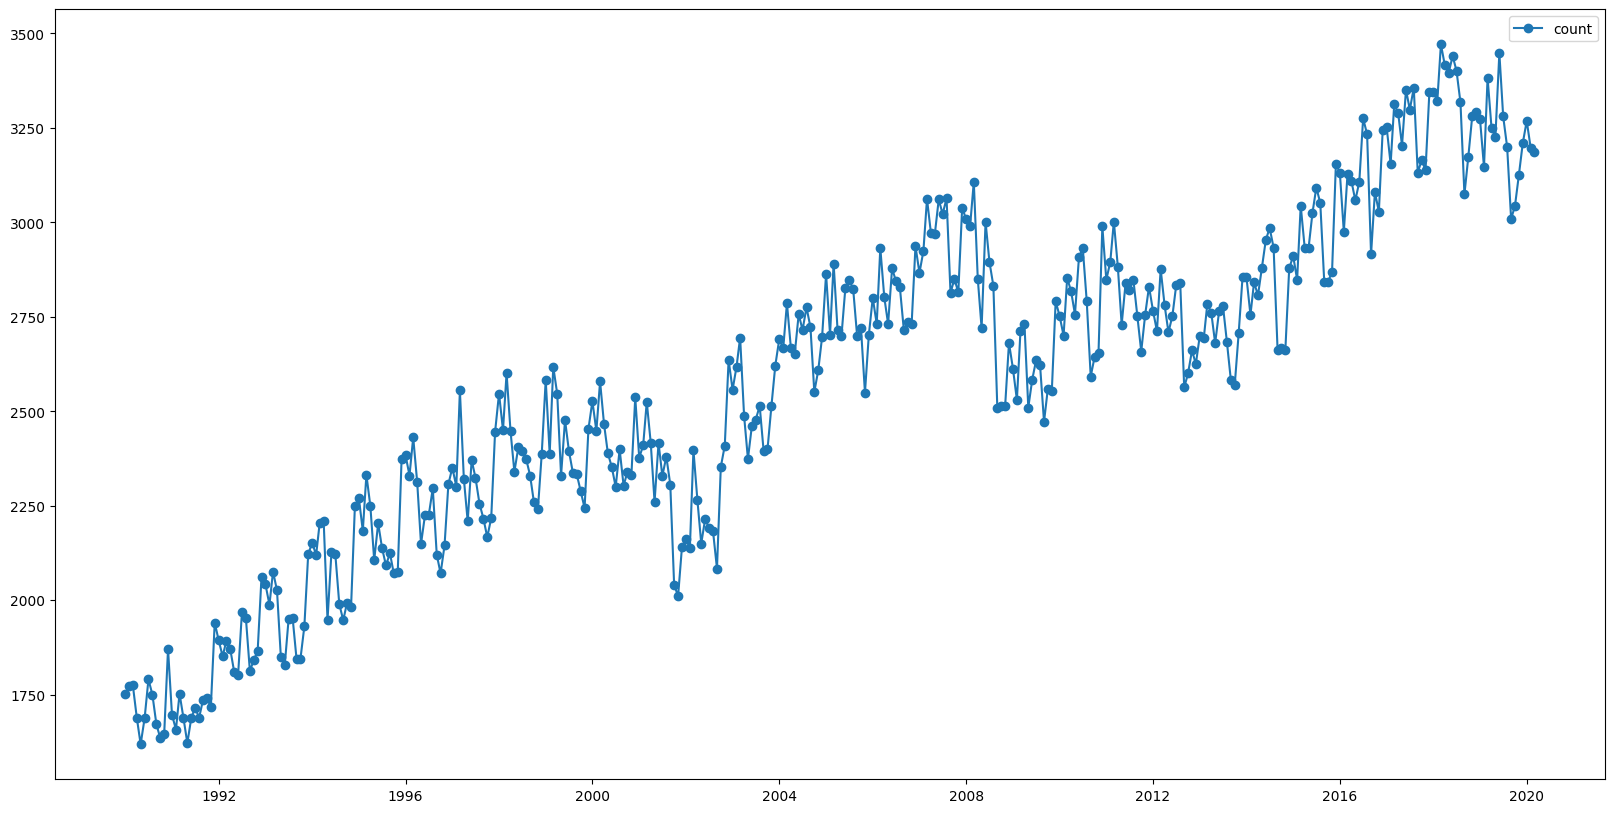

In [6]:
plot_time_series(['count'], dept_3)

<style>
    .my-background {
        background-color: #36c0e3; /* Specify your desired color */
        padding: 10px;
        color: #000000;
        border-radius: 10px; /* Adjust the radius as needed */
    
        
    }
</style>

<div class="my-background">
    <h1>Time Series Stationarity</h1>
    <!-- Add your content here -->
</div>

In [9]:
# make dept_3 index as date
dept_4 = dept_3.set_index('date')
dept_4.index = pd.to_datetime(dept_4.index)
dept_4.head()

,count
date,
1990-01-01,1751
1990-02-01,1774
1990-03-01,1775
1990-04-01,1689
1990-05-01,1619


Text(0.513, 0.95, 'International Airline Departure Data')

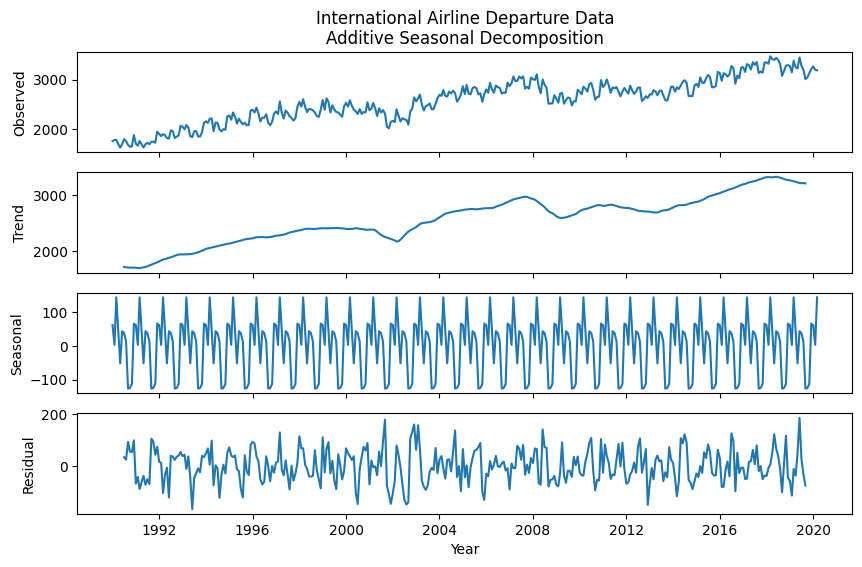

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose, DecomposeResult
sea_decomp = seasonal_decompose(dept_4, model="additive")
# let's plot the seasonal decomposition

fig, axes = plt.subplots(4, 1, figsize=(10, 6), sharex=True)

axes[0].set_title("Additive Seasonal Decomposition")
axes[0].plot(sea_decomp.observed) # original/observed data
axes[0].set_ylabel("Observed")

axes[1].plot(sea_decomp.trend) # trend component
axes[1].set_ylabel("Trend")

axes[2].plot(sea_decomp.seasonal)
axes[2].set_ylabel("Seasonal") # seasonality component 

axes[3].plot(sea_decomp.resid) #  time series with the trend and seasonal components removed
axes[3].set_ylabel("Residual")

axes[3].set_xlabel("Year")
fig.suptitle("International Airline Departure Data", x=0.513, y=0.95)

<style>
    .my-background {
        background-color: #36c0e3; /* Specify your desired color */
        padding: 10px;
        color: #000000;
        border-radius: 10px; /* Adjust the radius as needed */
    
        
    }
</style>

<div class="my-background">
    <h3>Original Time Series</h3>
    <!-- Add your content here -->
</div>

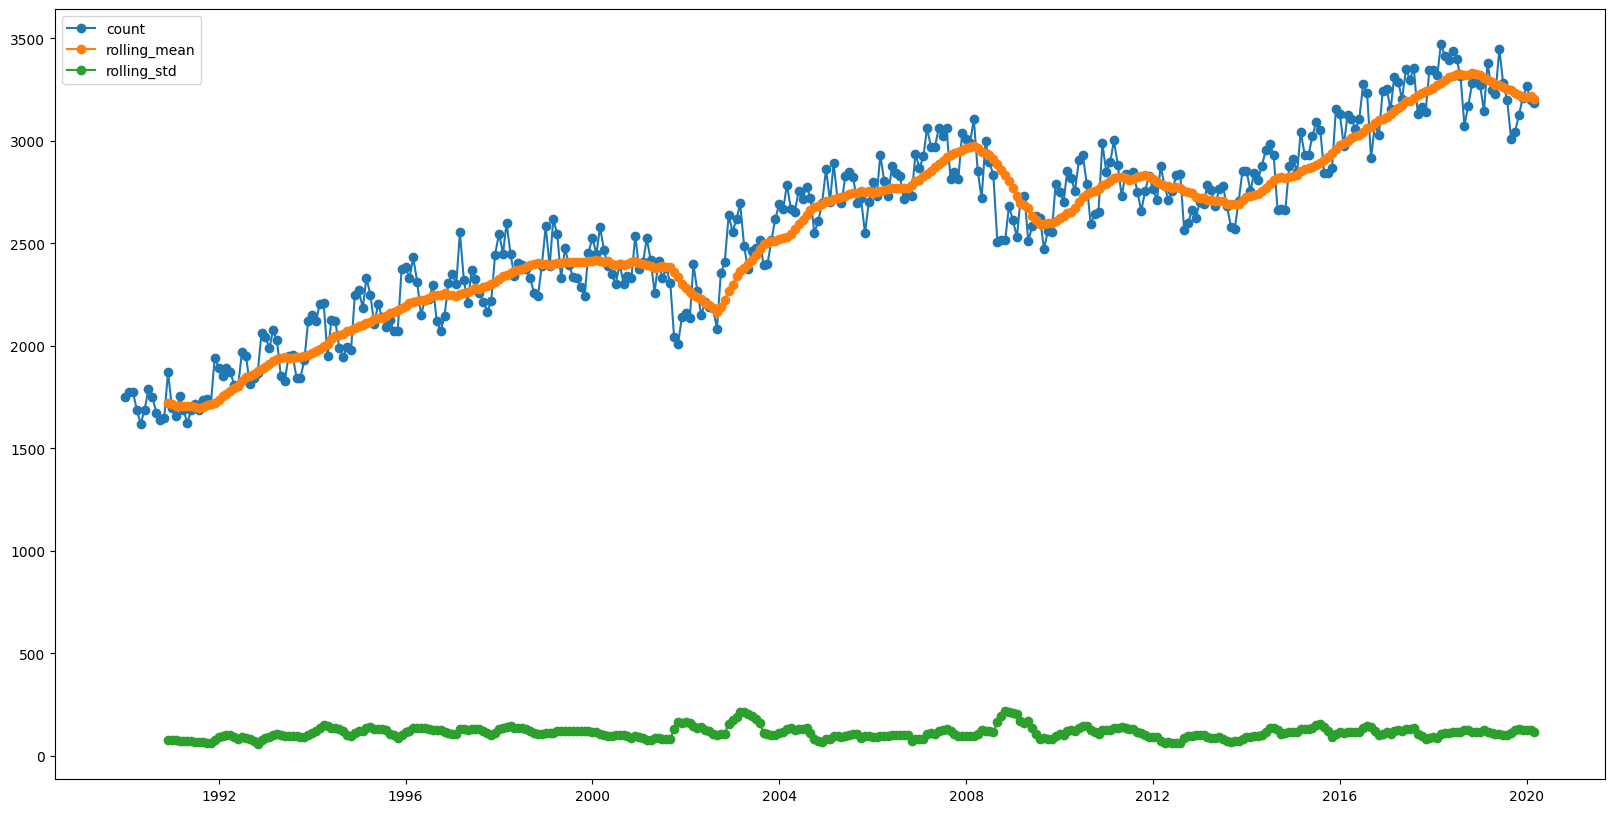

In [8]:
# take the rollong mean and rolling std of the data
dept_3['rolling_mean'] = dept_3['count'].rolling(window=12).mean()
dept_3['rolling_std'] = dept_3['count'].rolling(window=12).std()

# draw a line plot
list = ['count', 'rolling_mean', 'rolling_std']
plot_time_series(list, dept_3)

The Rolling std deviation seems stationary but Rolling mean is fluctuating

<style>
    .my-background {
        background-color: #36c0e3; /* Specify your desired color */
        padding: 10px;
        color: #000000;
        border-radius: 10px; /* Adjust the radius as needed */
    
        
    }
</style>

<div class="my-background">
    <h3>Differenced Series Stationarity</h3>
    <!-- Add your content here -->
</div>

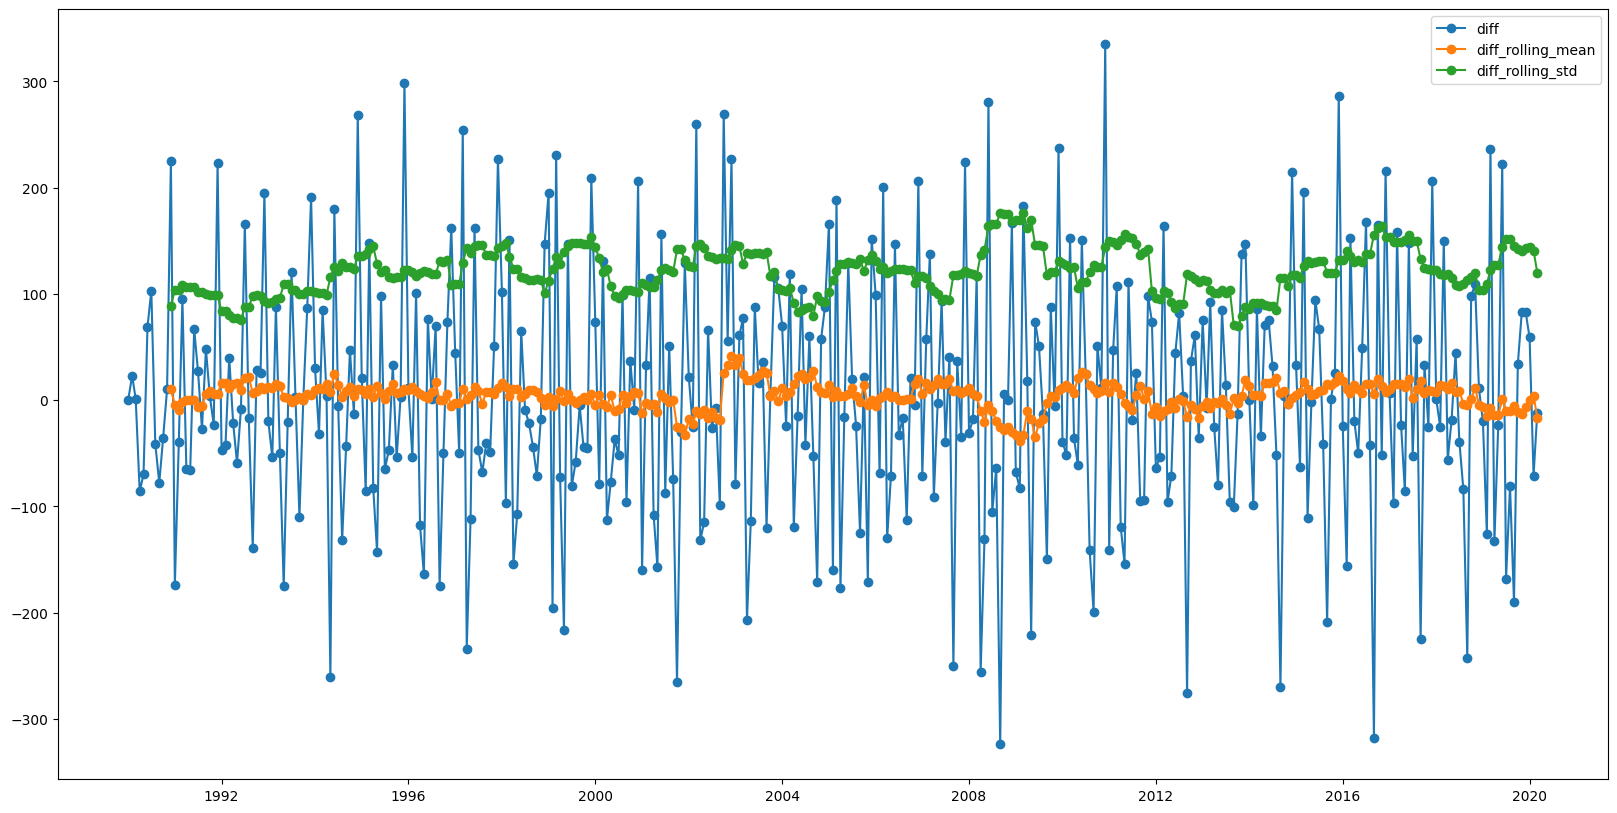

In [9]:
# use differencing
dept_3['diff'] = dept_3['count'].diff()
dept_3['diff'].fillna(0, inplace=True)
dept_3['diff_rolling_mean'] = dept_3['diff'].rolling(window=12).mean()
dept_3['diff_rolling_std'] = dept_3['diff'].rolling(window=12).std()

# draw a line plot
list = ['diff', 'diff_rolling_mean', 'diff_rolling_std']
plot_time_series(list, dept_3)


<style>
    .my-background {
        background-color: #36c0e3; /* Specify your desired color */
        padding: 10px;
        color: #000000;
        border-radius: 10px; /* Adjust the radius as needed */
    
        
    }
</style>

<div class="my-background">
    <h3>Log Time Series</h3>
    <!-- Add your content here -->
</div>

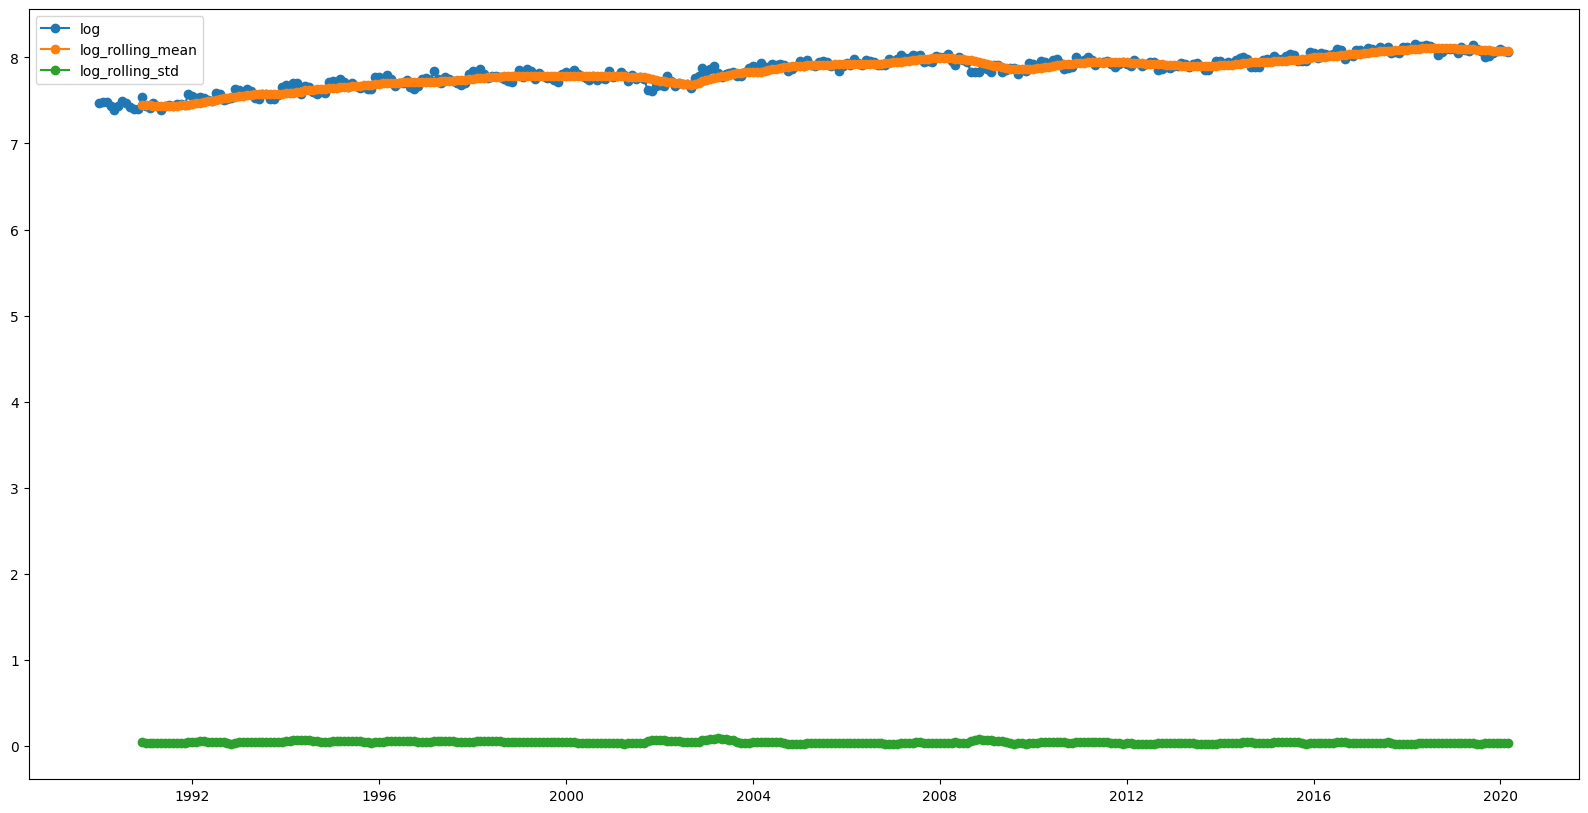

In [10]:
dept_3['log'] = np.log(dept_3['count'])
dept_3['log_rolling_mean'] = dept_3['log'].rolling(window=12).mean()
dept_3['log_rolling_std'] = dept_3['log'].rolling(window=12).std()

# draw a line plot
list = ['log', 'log_rolling_mean', 'log_rolling_std']
plot_time_series(list, dept_3)

<style>
    .my-background {
        background-color: #36c0e3; /* Specify your desired color */
        padding: 10px;
        color: #000000;
        border-radius: 10px; /* Adjust the radius as needed */
    
        
    }
</style>

<div class="my-background">
    <h3>ADF test</h3>
    <!-- Add your content here -->
</div>

In [11]:
# ADF test
from statsmodels.tsa.stattools import adfuller

def adf_test(df):
    result = adfuller(df)
    print('    ADF Statistic: %f' % result[0])
    print('    p-value: %f' % result[1])

print('Original Time Series')
adf_test(dept_3['count'])
print('Differenced Time series')
adf_test(dept_3['diff'].dropna())
print('Log Time series')
adf_test(dept_3['log'].dropna())

Original Time Series
    ADF Statistic: -1.829860
    p-value: 0.365741
Differenced Time series
    ADF Statistic: -4.895917
    p-value: 0.000036
Log Time series
    ADF Statistic: -2.313881
    p-value: 0.167530


In the Augmented Dickey-Fuller (ADF) test, which is commonly used to test for stationarity in a time series dataset, the p-value serves as a measure to determine the significance of the test results. 

For a significance level (alpha) of 5%, the threshold for the p-value in the ADF test is typically less than 0.05. Here are the hypothesis conditions:

- **Null Hypothesis (H0)**: The null hypothesis assumes that the time series data is non-stationary, implying it possesses a unit root (i.e., it's not stationary).
- **Alternative Hypothesis (H1)**: The alternative hypothesis contradicts the null hypothesis. It suggests that the time series data is stationary (i.e., no unit root).

Interpreting the p-value in the ADF test:
- If the p-value is less than the chosen significance level (alpha), such as 0.05, it provides evidence to reject the null hypothesis (H0). In this case, it suggests that the time series data is stationary.
- Conversely, if the p-value is greater than the significance level (alpha), there's insufficient evidence to reject the null hypothesis. It indicates that the time series data is non-stationary and likely possesses a unit root.

Remember, the choice of significance level (alpha) can vary depending on the context of the analysis and the potential consequences of making Type I and Type II errors in the statistical test.

<font color = '#36c0e3'>
Hence, the Differenced Time Series is Stationary
</font>

<style>
    .my-background {
        background-color: #36c0e3; /* Specify your desired color */
        padding: 10px;
        color: #000000;
        border-radius: 10px; /* Adjust the radius as needed */
    
        
    }
</style>

<div class="my-background">
    <h3>ACF and PACF plots</h3>
    <!-- Add your content here -->
</div>

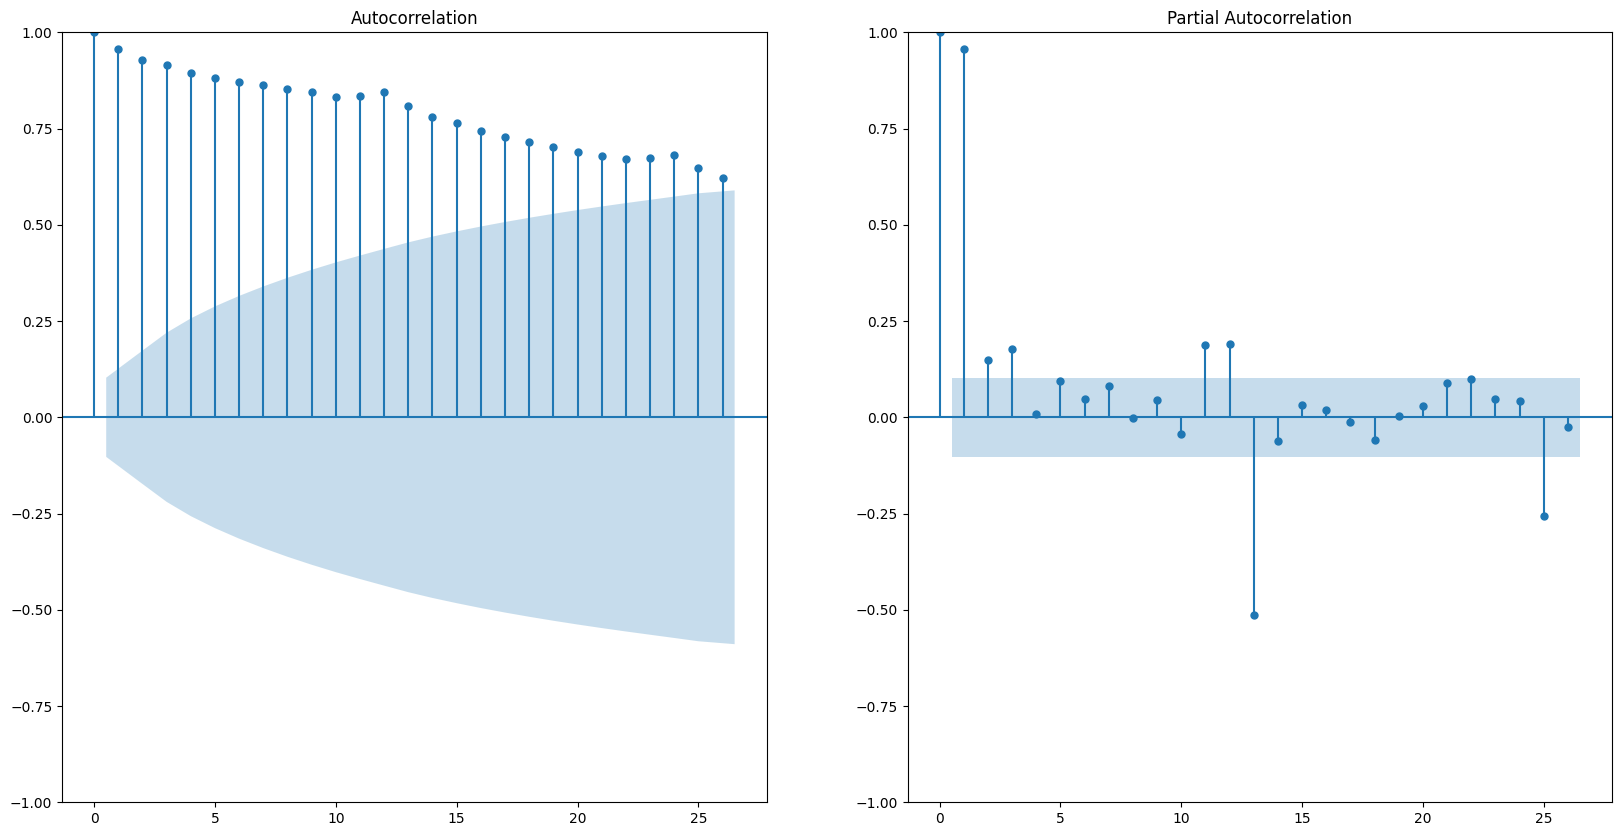

In [12]:
# plot the ACF and PACF plots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
plot_acf(dept_3['count'].dropna(), ax=ax1)
plot_pacf(dept_3['count'].dropna(), ax=ax2)
plt.show()

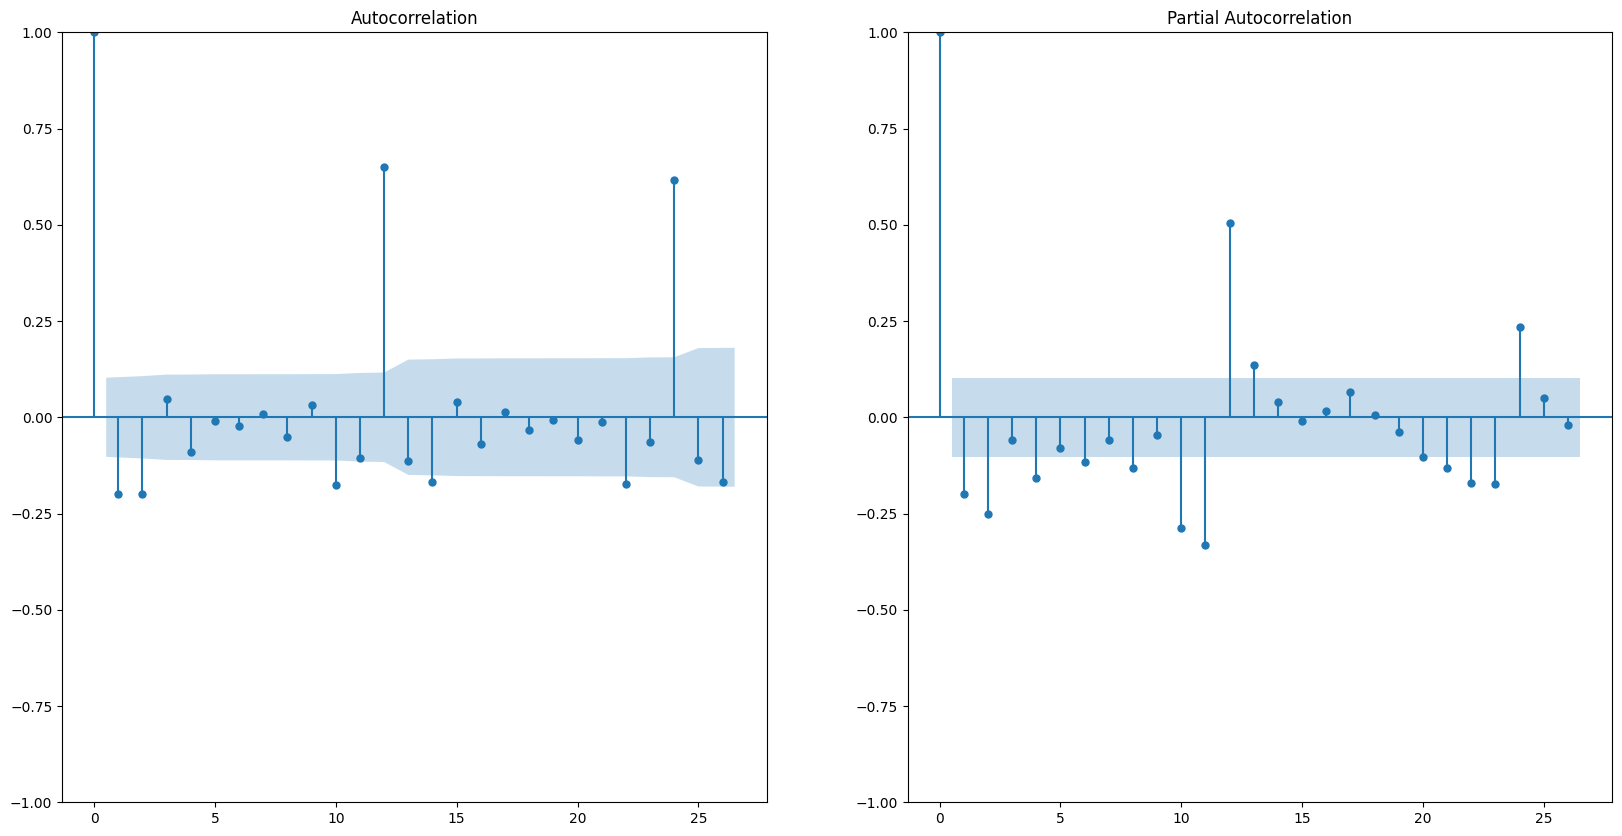

In [13]:
# plot the ACF and PACF plots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
plot_acf(dept_3['diff'].dropna(), ax=ax1)
plot_pacf(dept_3['diff'].dropna(), ax=ax2)
plt.show()

<style>
    .my-background {
        background-color: #43d143; /* Specify your desired color */
        padding: 10px;
        color: #000000;
        border-radius: 10px; /* Adjust the radius as needed */
    
        
    }
</style>

<div class="my-background">
    <h1>ARIMA models</h1>
    <!-- Add your content here -->
</div>

In [14]:
# train uptill 2015 and test onwards
train_ts = dept_3[dept_3['date'] < '2015-01-01']
test_ts = dept_3[dept_3['date'] >= '2015-01-01']

In [15]:
train_ts.tail()

,date,count,rolling_mean,rolling_std,diff,diff_rolling_mean,diff_rolling_std,log,log_rolling_mean,log_rolling_std
295,2014-08-01,2933,2809.833333,134.626644,-52.0,20.833333,84.510175,7.983781,7.939805,0.048707
296,2014-09-01,2663,2816.583333,123.756696,-270.0,6.750000,115.176643,7.887209,7.942379,0.044531
297,2014-10-01,2667,2824.750000,108.187653,4.0,8.166667,115.016073,7.888710,7.945499,0.038466
298,2014-11-01,2663,2821.083333,113.172000,-4.0,-3.666667,107.503347,7.887209,7.944133,0.040335
299,2014-12-01,2878,2823.083333,114.015516,215.0,2.000000,117.495068,7.964851,7.944831,0.040639


<style>
    .my-background {
        background-color: #43d143; /* Specify your desired color */
        padding: 10px;
        color: #000000;
        border-radius: 10px; /* Adjust the radius as needed */
    
        
    }
</style>

<div class="my-background">
    <h3>Original Time Series</h3>
    <!-- Add your content here -->
</div>

c:\Users\prathuj\OneDrive - Umich\@SI670\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Execution time: 2.6509435176849365 seconds


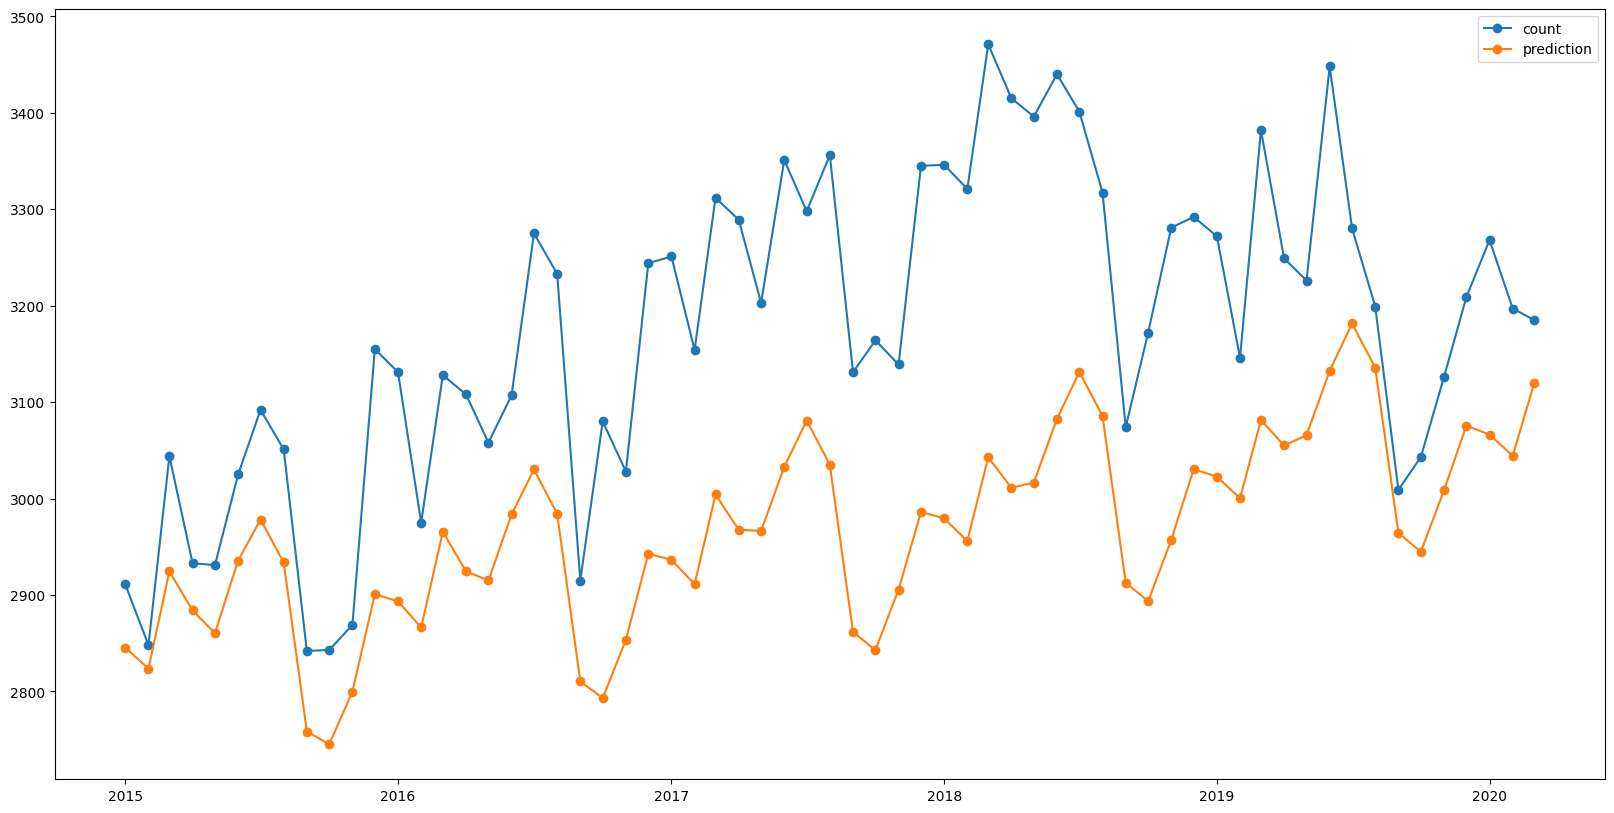

RMSE:  232.99129250340746


In [16]:
from statsmodels.tsa.arima.model import ARIMA
import time


model = ARIMA(train_ts['count'], order=(12, 2, 12))
start_time = time.time()
model_fit = model.fit()
end_time = time.time()
execution_time = end_time - start_time

print(f"Execution time: {execution_time} seconds")
# print(model_fit.summary())
prediction = model_fit.predict(start=test_ts.index[0], end=test_ts.index[- 1], typ='levels')
# add the predictions to the test data
test_ts['prediction'] = prediction

# plot the predictions for the test data
plot_time_series(['count', 'prediction'], test_ts)

# calculate the rmse
rmse = np.sqrt(mean_squared_error(test_ts['count'], test_ts['prediction']))
print('RMSE: ', rmse)

c:\Users\prathuj\OneDrive - Umich\@SI670\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Execution time: 2.4848484992980957 seconds


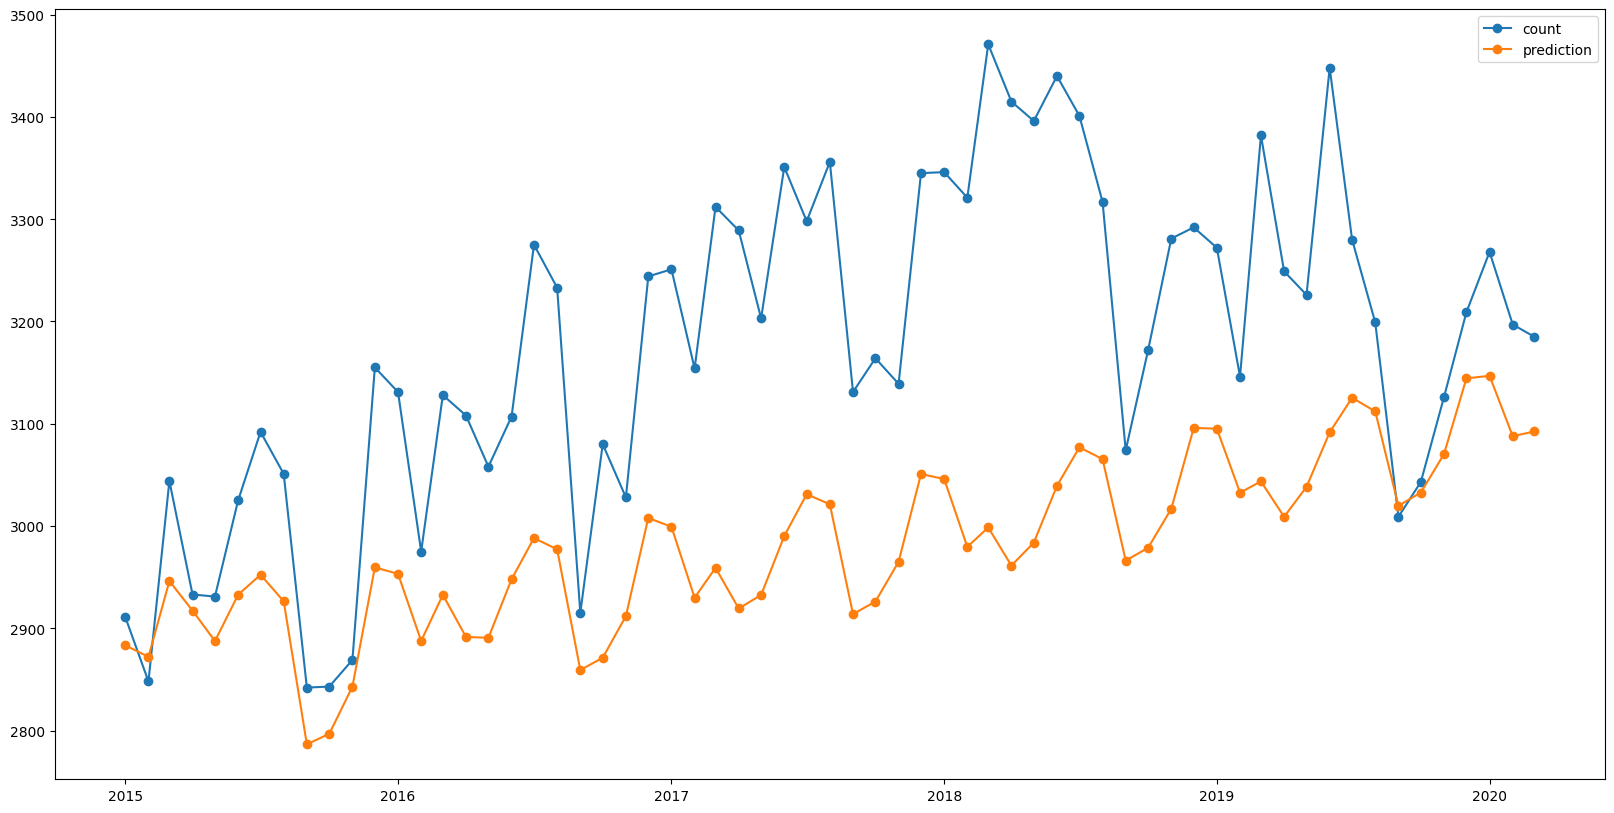

RMSE:  227.76600472452634


In [17]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train_ts['count'], order=(12, 3, 12))
start_time = time.time()
model_fit = model.fit()
end_time = time.time()
execution_time = end_time - start_time

print(f"Execution time: {execution_time} seconds")
# print(model_fit.summary())
prediction = model_fit.predict(start=test_ts.index[0], end=test_ts.index[- 1], typ='levels')
# add the predictions to the test data
test_ts['prediction'] = prediction

# plot the predictions for the test data
plot_time_series(['count', 'prediction'], test_ts)

# calculate the rmse
rmse = np.sqrt(mean_squared_error(test_ts['count'], test_ts['prediction']))
print('RMSE: ', rmse)

<style>
    .my-background {
        background-color: #43d143; /* Specify your desired color */
        padding: 10px;
        color: #000000;
        border-radius: 10px; /* Adjust the radius as needed */
    
        
    }
</style>

<div class="my-background">
    <h3>Differenced Time Series</h3>
    <!-- Add your content here -->
</div>

c:\Users\prathuj\OneDrive - Umich\@SI670\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Execution time: 2.1452293395996094 seconds


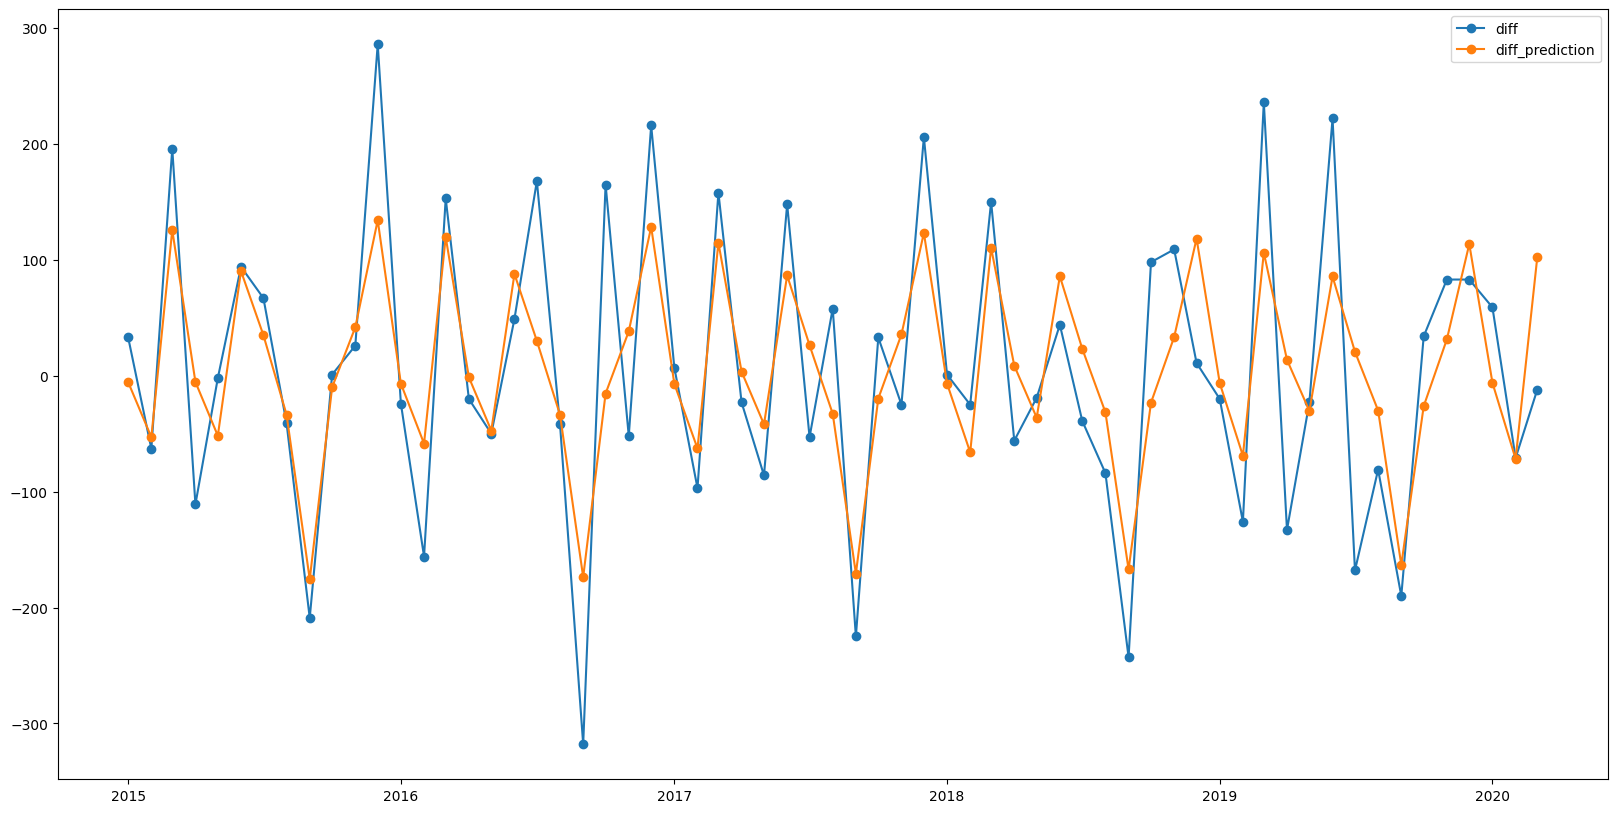

In [18]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train_ts['diff'], order=(12, 0, 12))
start_time = time.time()
model_fit = model.fit()
end_time = time.time()
execution_time = end_time - start_time

print(f"Execution time: {execution_time} seconds")
# print(model_fit.summary())
prediction = model_fit.predict(start=test_ts.index[0], end=test_ts.index[- 1], typ='levels')
# add the predictions to the test data
test_ts['diff_prediction'] = prediction

# plot the predictions for the test data
plot_time_series(['diff', 'diff_prediction'], test_ts)

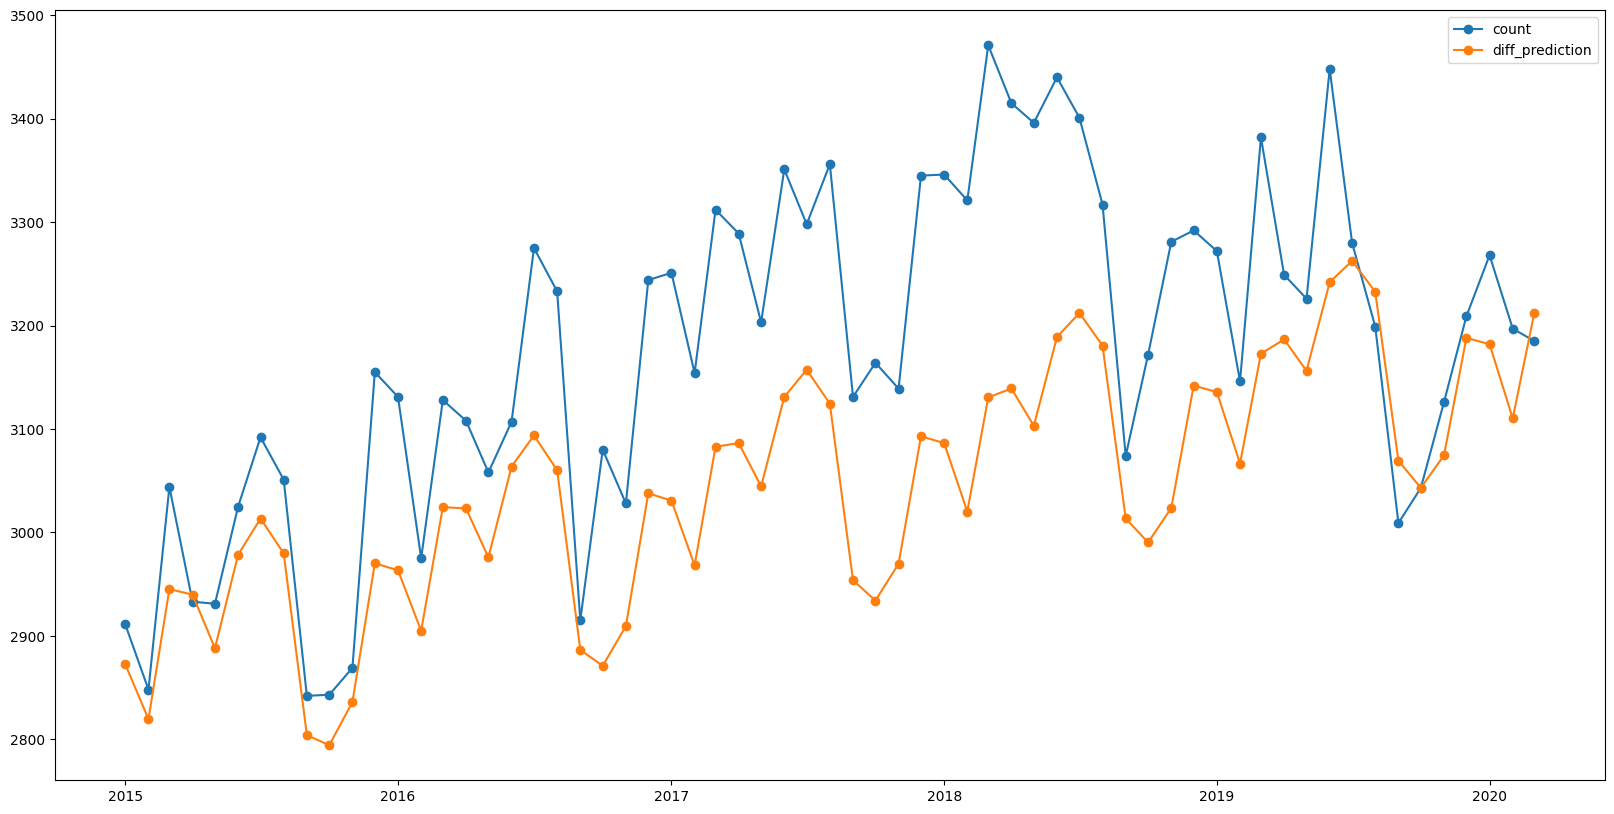

RMSE:  159.96615532647064


In [19]:
# reverse the differencing
test_ts['diff_prediction'] = test_ts['diff_prediction'].cumsum()
test_ts['diff_prediction'] = test_ts['diff_prediction'] + train_ts['count'].iloc[-1]
# plot the predictions for the test data
plot_time_series(['count', 'diff_prediction'], test_ts)

# calculate the rmse
rmse = np.sqrt(mean_squared_error(test_ts['count'], test_ts['diff_prediction']))
print('RMSE: ', rmse)

<style>
    .my-background {
        background-color: #ff9933; /* Specify your desired color */
        padding: 10px;
        color: #000000;
        border-radius: 10px; /* Adjust the radius as needed */
    
        
    }
</style>

<div class="my-background">
    <h1>Neural Network Modelling</h1>
    <!-- Add your content here -->
</div>

Neural network model selection for time series analysis:

- **CNN (Convolutional Neural Networks):** CNNs are primarily used for image data due to their ability to capture spatial information through convolutions. For time series, they can be applied when there's a spatial aspect or if you're working with 2D time series data (e.g., spectrograms, sensor arrays).

- **RNN (Recurrent Neural Networks):** RNNs are designed for sequence data and can handle variable-length sequences. However, traditional RNNs might suffer from the vanishing gradient problem, limiting their ability to capture long-term dependencies.

- **LSTM (Long Short-Term Memory) Networks:** LSTMs are a type of RNN designed to mitigate the vanishing gradient problem. They are effective for modeling long sequences and retaining memory over longer periods, making them particularly useful for time series forecasting tasks.

For time series analysis, particularly in forecasting scenarios with sequential dependencies and long-term memory requirements, LSTM networks are often preferred due to their ability to capture long-range dependencies and remember information over extended periods, which is crucial for accurate predictions.

<style>
    .my-background {
        background-color: #ff9933; /* Specify your desired color */
        padding: 10px;
        color: #000000;
        border-radius: 10px; /* Adjust the radius as needed */
    
        
    }
</style>

<div class="my-background">
    <h3>Dense Neural Network</h3>
    <!-- Add your content here -->
</div>

In [20]:
window_size = 3

# create a list of lists containing the windowed data
X = [dept_3['count'][i: i + window_size].values for i in range(len(dept_3) - window_size)]
# convert the list of lists to a dataframe
X = pd.DataFrame(X)
# create the target variable
y = dept_3['count'][window_size:]
y = pd.DataFrame(y)

X_train, X_test_original, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
X_train.shape, X_test_original.shape, y_train.shape, y_test.shape

((288, 3), (72, 3), (288, 1), (72, 1))


Epoch 1/100

288/288 [==============================] - 1s 2ms/step - loss: 141020.3594
Epoch 2/100
288/288 [==============================] - 0s 1ms/step - loss: 17053.4023
Epoch 3/100
288/288 [==============================] - 0s 1ms/step - loss: 16896.5820
Epoch 4/100
288/288 [==============================] - 0s 1ms/step - loss: 17023.8086
Epoch 5/100
288/288 [==============================] - 0s 1ms/step - loss: 16229.8389
Epoch 6/100
288/288 [==============================] - 0s 1ms/step - loss: 17248.4141
Epoch 7/100
288/288 [==============================] - 0s 1ms/step - loss: 16918.5078
Epoch 8/100
288/288 [==============================] - 0s 1ms/step - loss: 15217.3477
Epoch 9/100
288/288 [==============================] - 0s 1ms/step - loss: 16390.0137
Epoch 10/100
288/288 [==============================] - 0s 1ms/step - loss: 15839.4639
Epoch 11/100
288/288 [==============================] - 0s 1ms/step - loss: 15478.2148
Epoch 12/100
288/288 [===========================

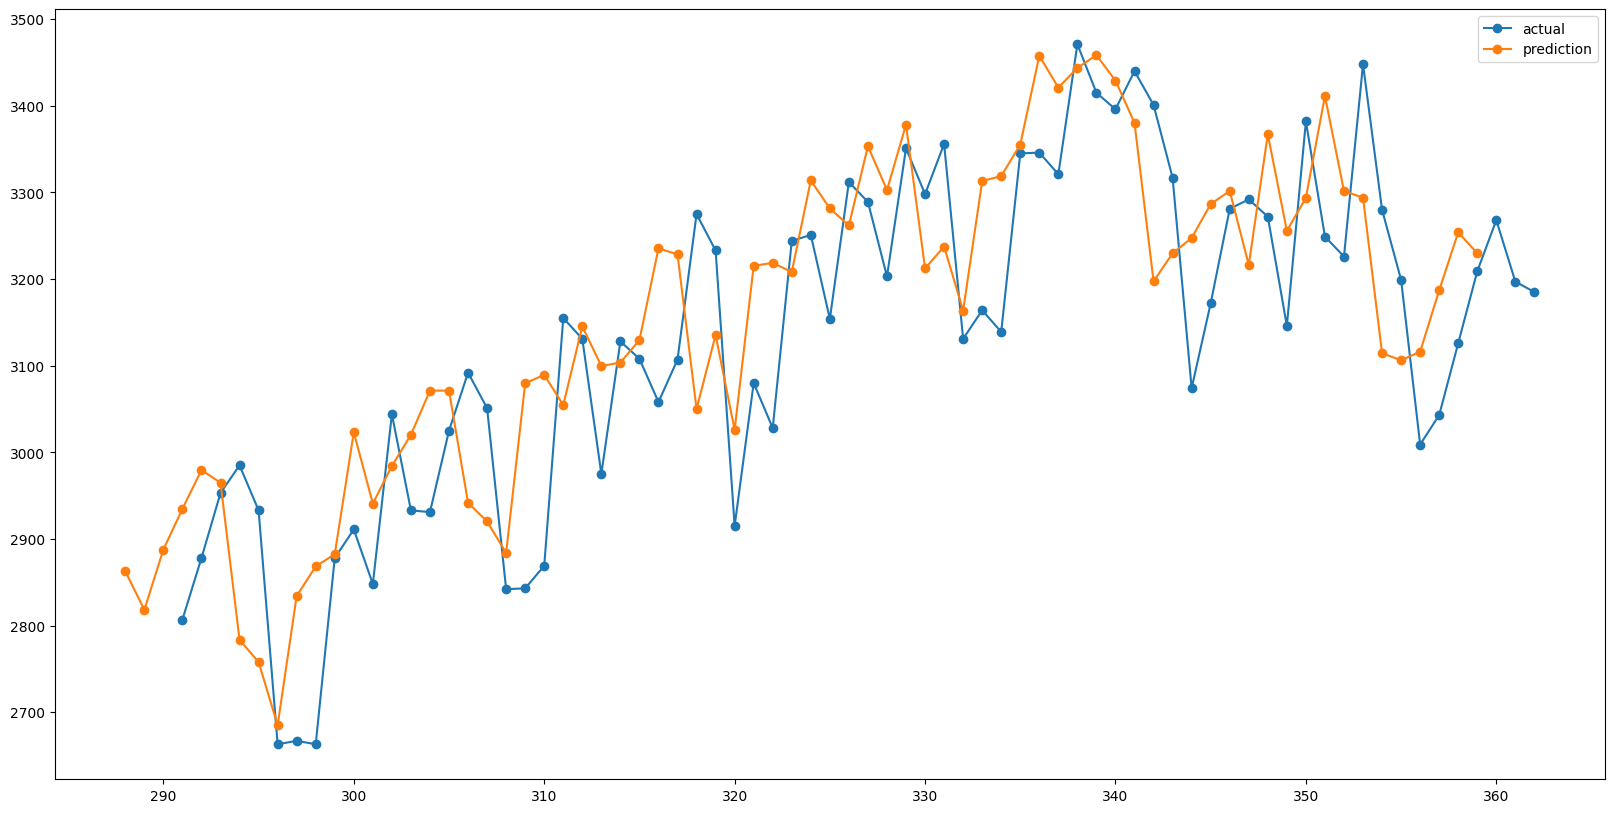

In [23]:
# Define the MLP model
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))  # Output layer
model.compile(loss='mean_squared_error', optimizer='adam')

start_time = time.time()
model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=1)
end_time = time.time()
execution_time = end_time - start_time

print(f"Execution time: {execution_time} seconds")

X_test = X_test_original.copy()
# predict on the test data
prediction = model.predict(X_test)
# add the predictions to the test data
X_test['prediction'] = prediction
# calculate the rmse
rmse = np.sqrt(mean_squared_error(y_test, X_test['prediction']))
print('RMSE: ', rmse)

# plot the predictions for the test data
plt.figure(figsize=(20, 10))
plt.plot(y_test, label='actual', marker='o')
plt.plot(X_test['prediction'], label='prediction', marker='o')
plt.legend()
plt.show()

<style>
    .my-background {
        background-color: #ff9933; /* Specify your desired color */
        padding: 10px;
        color: #000000;
        border-radius: 10px; /* Adjust the radius as needed */
    
        
    }
</style>

<div class="my-background">
    <h3>LSTM Neural Network</h3>
    <!-- Add your content here -->
</div>

In [130]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [131]:
train = dept_3[dept_3['date'] < '2015-01-01']
test = dept_3[dept_3['date'] >= '2015-01-01']

var = np.array(train['count']).reshape(-1, 1)
# create a generator
n_input = 48
n_features = 1
generator = TimeseriesGenerator(var, var, length=n_input, batch_size=1)

In [132]:
X , y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[1751 1774 1775 1689 1619 1688 1791 1750 1672 1636 1646 1871 1697 1658
 1753 1688 1622 1689 1716 1689 1737 1741 1718 1941 1894 1852 1892 1870
 1811 1803 1969 1952 1813 1841 1867 2062 2042 1988 2076 2026 1851 1830
 1951 1954 1844 1844 1931 2122]
Predict this y: 
 [[2152]]


In [133]:
X.shape

(1, 48, 1)

In [134]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# define model
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [135]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 64)                16896     
                                                                 
 dense_10 (Dense)            (None, 1)                 65        
                                                                 
Total params: 16961 (66.25 KB)
Trainable params: 16961 (66.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [136]:
# fit model
start_time = time.time()
model.fit_generator(generator, epochs=50)
end_time = time.time()
execution_time = end_time - start_time

print(f"Execution time: {execution_time} seconds")

Epoch 1/50
252/252 [==============================] - 3s 8ms/step - loss: 22921802.0000
Epoch 2/50
252/252 [==============================] - 2s 9ms/step - loss: 5677234.0000
Epoch 3/50
252/252 [==============================] - 2s 8ms/step - loss: 2678791.5000
Epoch 4/50
252/252 [==============================] - 2s 8ms/step - loss: 4821071.5000
Epoch 5/50
252/252 [==============================] - 2s 8ms/step - loss: 15077174.0000
Epoch 6/50
252/252 [==============================] - 2s 8ms/step - loss: 72226.0234
Epoch 7/50
252/252 [==============================] - 2s 7ms/step - loss: 148479.0156
Epoch 8/50
252/252 [==============================] - 2s 8ms/step - loss: 70788.1875
Epoch 9/50
252/252 [==============================] - 2s 8ms/step - loss: 80244.3594
Epoch 10/50
252/252 [==============================] - 2s 8ms/step - loss: 76223.1797
Epoch 11/50
252/252 [==============================] - 2s 8ms/step - loss: 94929.8828
Epoch 12/50
252/252 [=============================

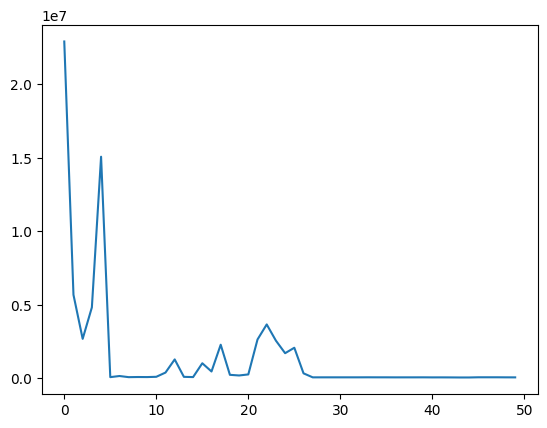

In [137]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)), loss_per_epoch)

In [138]:
last_train_batch = var[-n_input:] 

In [139]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [140]:
model.predict(last_train_batch)

1/1 [==============================] - 0s 184ms/step


array([[3076.0625]], dtype=float32)

In [141]:
test['count'].iloc[0]

2911

In [142]:
test_predictions = []

first_eval_batch = var[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    current_pred = model.predict(current_batch)[0]
    test_predictions.append(current_pred)
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)

1/1 [==============================] - 0s 28ms/step


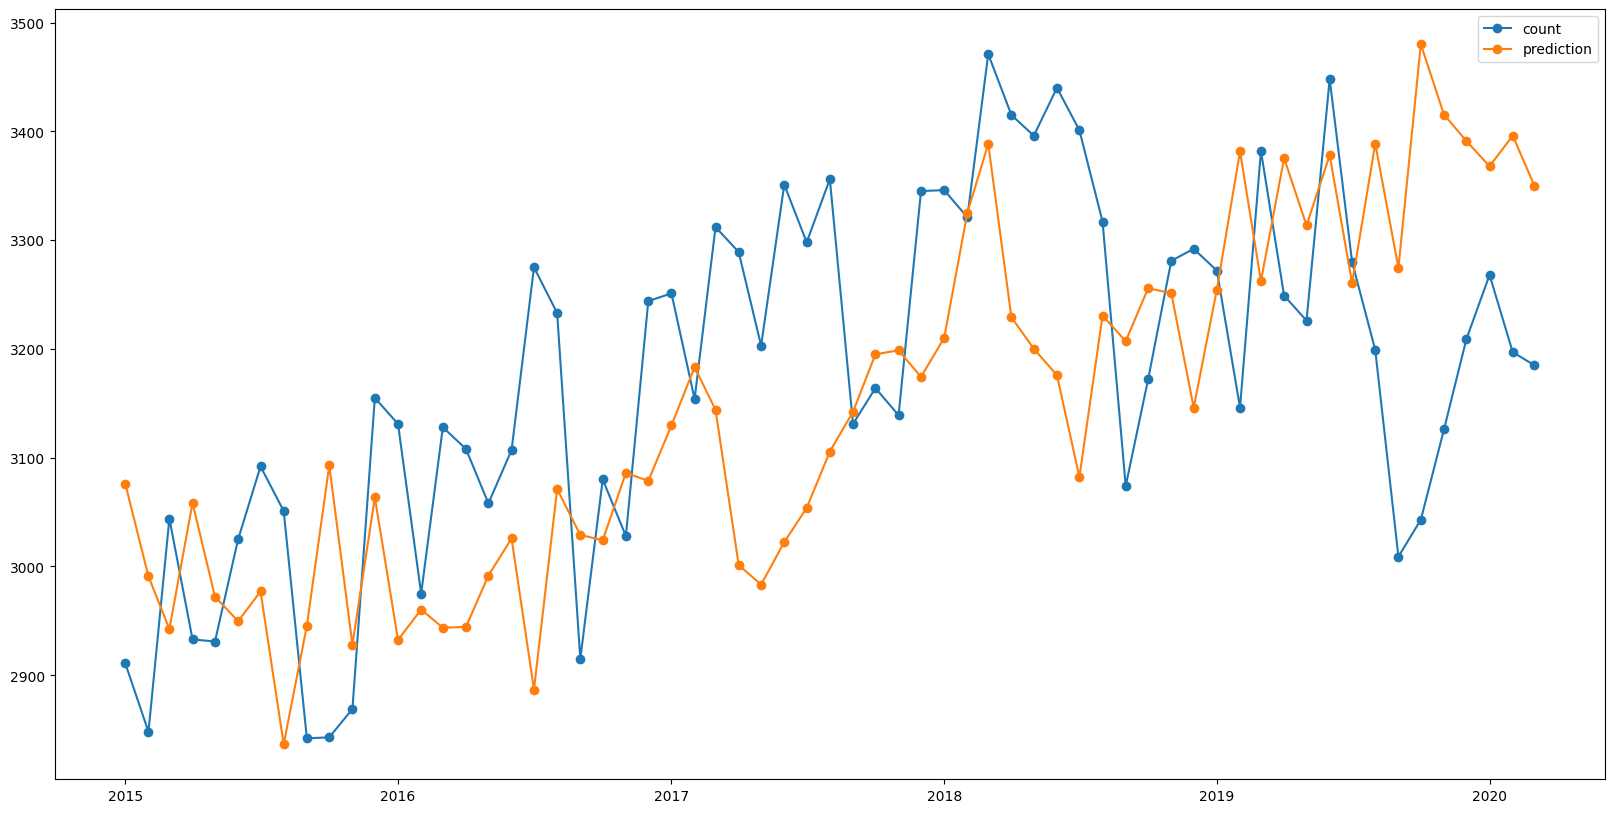

In [143]:
# take the predictions and add them to the test data
test['prediction'] = test_predictions
# plot the predictions for the test data
plot_time_series(['count', 'prediction'], test)

In [144]:
# compute the rmse
rmse = np.sqrt(mean_squared_error(test['count'], test['prediction']))
print('RMSE: ', rmse)

RMSE:  174.2705251735084
